# Projeto

## Bibliotecas

### Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

### Torch Vision

In [ ]:
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100

### Extras

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
%matplotlib inline

## Configurações Globais

In [ ]:
torch.manual_seed(7)

## Funções Auxiliares

In [ ]:
def plot_data(batch,classes,limit = 20,figsize = (10,10),n = 25, nrow = 5):
  images,labels = batch
  fig,ax = plt.subplots(figsize = figsize)
  ax.imshow(make_grid(images[:limit],nrow = 5).permute(1,2,0))
  title = [classes[int(i)] for i in labels]
  ax.set_title(str(title))
  plt.show()

In [ ]:
def get_batch(dataloader):
  for batch in dataloader:
    return batch

In [ ]:
def get_device():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #print("Device: ", device)
  return device

In [ ]:
def export_to_onnx(model):
  dummy_dataloader = DataLoader(torch.randn(1, 3, 32, 32),batch_size = 1)
  dummy_input = next(iter(dummy_dataloader))
  dummy_input = dummy_input.to(get_device())
  torch.onnx.export(model,dummy_input,'model.onnx')

In [ ]:
def predict_image(model,image,classes = None):
  model.eval()
  image = image.to(get_device())
  output = model(image.unsqueeze(0))
  _,prediction = torch.max(output,1)
  if classes == None:
    return prediction.item()
  return classes[int(prediction.item())]

In [ ]:
def predict(model,data):
  prediction = [predict_image(model,image) for image,label in data]
  return prediction

In [ ]:
def fit(model,dl_train,num_epochs = 5, loss_function = nn.CrossEntropyLoss(), lr = 1e-2, optimizer = None,steps = 2000):
  device = get_device()
  model = model.to(device)
  if optimizer == None:
    optimizer = torch.optim.SGD(model.parameters(),lr = lr)

  model.train() # sets the model for training mode
  for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (data,targets) in enumerate(dl_train):
      data = data.to(device) # send the images to the GPU (if available)
      targets = targets.to(device) # send the labels to the GPU (if available)
      optimizer.zero_grad()

      outputs = model(data) # get the predicted results
      loss = loss_function(outputs,targets) #calculates the loss
      loss.backward() # calculates the derivative of the loss
      optimizer.step() # updates the parameters
      running_loss += loss.item()
      
      if (i+1) % steps == 0:
        print("Epoch: ", "[" + str(epoch+1) + "/" + str(num_epochs)+ "]" + ":", "Loss :", running_loss/steps, "Step:", i+1)
        running_loss = 0.0
  print('The Training is Finished')

In [ ]:
def test(model,dl_test):
  device = get_device()
  correct = 0
  total = 0
  model.eval() #sets model to evaluation model (the dropout layer works differently in evaluation)
  with torch.no_grad():
    for data,labels in dl_test:
      data = data.to(device) # sends data to GPU (if available)
      labels = labels.to(device) # sends labels to GPU (if available)
      outputs = model(data) # Gets the outputs of the model
      _,predicted = torch.max(outputs.data,1) #Gets which numbers where predicted by the model
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print("Accuracy = ",correct,'/', total,(correct/total)*100,'%')

In [ ]:
def plot_confusion_matrix(y_test,y_pred, classes, title = 'Confusion Matrix',figsize = (10,10), fontsize = 20,fmt = 'd'):
  cm = confusion_matrix(y_test,y_pred)
  plt.figure(figsize = figsize)
  plt.title(title,fontsize = fontsize + int(0.5*fontsize))
  s = sns.heatmap(cm, annot = True, xticklabels = classes, yticklabels = classes,fmt = fmt)
  s.set_xlabel('Predicted Label',fontsize = fontsize)
  s.set_ylabel('True Label', fontsize = fontsize)
  plt.show()

## Cifar10

### Apagando os Dados (Se houver)

In [ ]:
%cd data
!rm -rf *
%cd ..
!ls

[Errno 2] No such file or directory: 'data'
/content
/
bin	 datalab  home	 lib64	opt	    root  srv		     tmp    var
boot	 dev	  lib	 media	proc	    run   sys		     tools
content  etc	  lib32  mnt	python-apt  sbin  tensorflow-1.15.2  usr


### Transformações

In [ ]:
stats = ((0.4914,0.4822,0.4465),(0.247,0.243,0.261))

train_transforms = transforms.Compose({
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
})

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(*stats)
])

In [ ]:
ds_train = CIFAR10('data/', train = True, download = True,transform = train_transforms)
ds_test =  CIFAR10('data/', train = False, download = True, transform = test_transforms)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
print(len(ds_train))
print(len(ds_test))

50000
10000


In [ ]:
classes = ds_train.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
print(ds_train)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )


In [ ]:
image,label = ds_train[0]
print(image.shape)

torch.Size([3, 32, 32])


### Dataloaders

In [ ]:
batch_size = 20
dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
dl_test =  DataLoader(ds_test, batch_size = batch_size, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


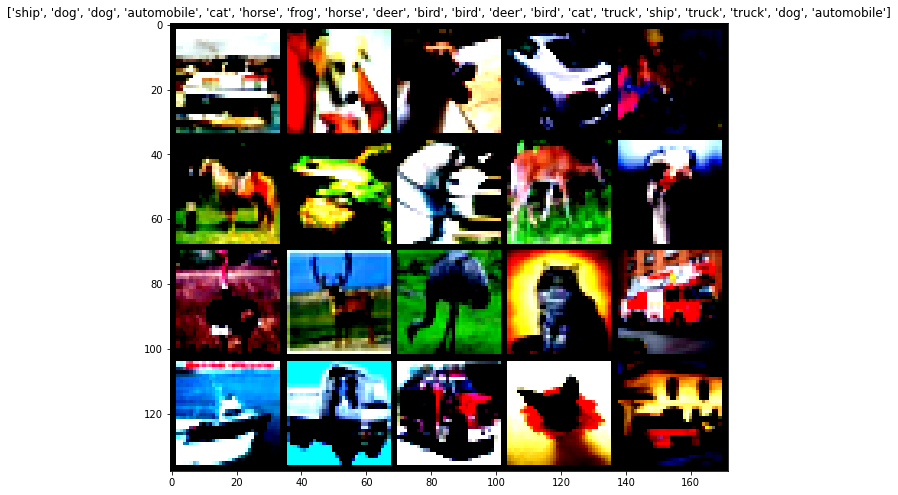

In [ ]:
batch = get_batch(dl_train)
plot_data(batch,classes)

### O Nosso Modelo Proposto

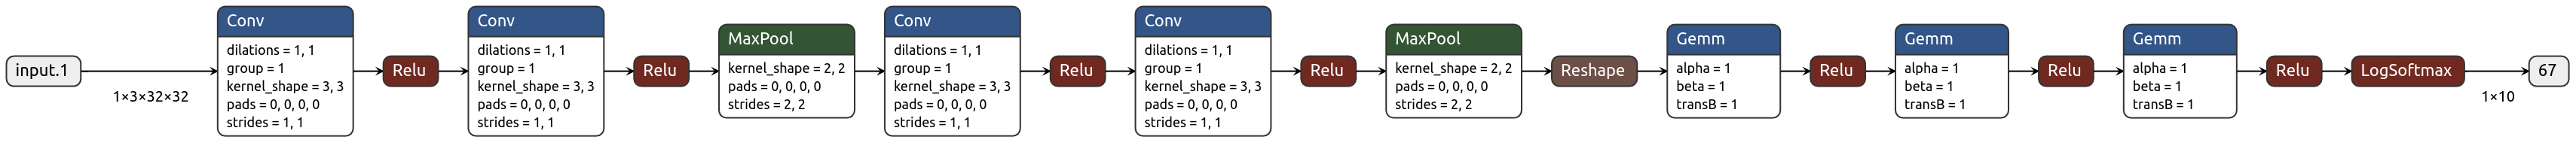

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 3)
    self.conv1_bn = nn.BatchNorm2d(24)
    self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 72, kernel_size = 3)
    self.conv2_bn = nn.BatchNorm2d(72)
    self.conv3 = nn.Conv2d(in_channels = 72, out_channels = 72, kernel_size = 3)
    self.conv3_bn = nn.BatchNorm2d(72)
    self.conv4 = nn.Conv2d(in_channels = 72, out_channels = 216, kernel_size = 3)
    self.conv4_bn = nn.BatchNorm2d(216)
    self.pool = nn.MaxPool2d(kernel_size = 2)
    self.dropout = nn.Dropout(p = 0.2)
    self.fc1 = nn.Linear(216*5*5, 600)
    self.fc1_bn = nn.BatchNorm1d(600)
    self.fc2 = nn.Linear(600,200)
    self.fc2_bn = nn.BatchNorm1d(200)
    self.fc3 = nn.Linear(200,10)
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.conv1_bn(x))
    x = self.conv2(x)
    x = F.relu(self.conv2_bn(x))
    x = self.pool(x)

    x = self.conv3(x)
    x = F.relu(self.conv3_bn(x))
    x = self.conv4(x)
    x = F.relu(self.conv4_bn(x))
    x = self.pool(x)

    x = x.view(-1,216*5*5)
   
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc1_bn(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    #x = self.fc2_bn(x)
    
    x = F.relu(self.fc3(x))
    return F.log_softmax(x,dim=1)

In [ ]:
model = CNN()
print(model)
model = model.to(get_device())

CNN(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 72, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(72, 216, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=5400, out_features=600, bias=True)
  (fc1_bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc2_bn): BatchNorm1d(200,

#### Treino

In [ ]:
fit(model,dl_train,num_epochs = 10)

Epoch:  [1/10]: Loss : 1.4533864408433437 Step: 2000
Epoch:  [2/10]: Loss : 1.0095398227423429 Step: 2000
Epoch:  [3/10]: Loss : 0.836277445062995 Step: 2000
Epoch:  [4/10]: Loss : 0.7446099705249071 Step: 2000
Epoch:  [5/10]: Loss : 0.6778632072731853 Step: 2000
Epoch:  [6/10]: Loss : 0.6152933293543756 Step: 2000
Epoch:  [7/10]: Loss : 0.5666595119349659 Step: 2000
Epoch:  [8/10]: Loss : 0.532094113573432 Step: 2000
Epoch:  [9/10]: Loss : 0.49083344179950655 Step: 2000
Epoch:  [10/10]: Loss : 0.4557283436302096 Step: 2000
The Training is Finished


#### Test

In [ ]:
test(model,dl_test) # 10 epochs should be used at least

Accuracy =  8192 / 10000 81.92 %


#### Salvando o Modelo

In [ ]:
torch.save(model,'CNN.pkl')
model = torch.load('CNN.pkl')
export_to_onnx(model)

#### Métricas de Desempenho

In [ ]:
y_pred = predict(model,ds_test)
y_test = [label for image,label in ds_test]

In [ ]:
print(classification_report(y_test,y_pred,target_names = classes))

              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83      1000
  automobile       0.93      0.90      0.91      1000
        bird       0.74      0.75      0.74      1000
         cat       0.65      0.70      0.67      1000
        deer       0.79      0.80      0.80      1000
         dog       0.77      0.72      0.74      1000
        frog       0.86      0.86      0.86      1000
       horse       0.87      0.84      0.85      1000
        ship       0.89      0.90      0.90      1000
       truck       0.89      0.89      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



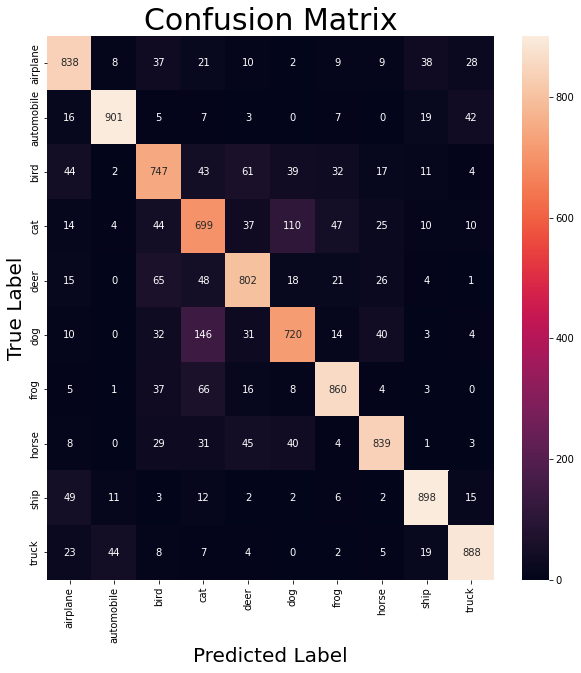

In [ ]:
plot_confusion_matrix(y_test,y_pred,classes)

## Cifar 100

### Limpando os Dados do Disco

In [ ]:
%cd data
!rm -rf *
%cd ..
!ls

/data
/
bin	 data	  home	 media	     proc	 sbin		    tmp
boot	 datalab  lib	 mnt	     python-apt  srv		    tools
CNN.pkl  dev	  lib32  model.onnx  root	 sys		    usr
content  etc	  lib64  opt	     run	 tensorflow-1.15.2  var


### Transformações

In [ ]:
stats = ((0.4914,0.4822,0.4465),(0.247,0.243,0.261))

train_transforms = transforms.Compose({
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
})

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(*stats)
])

### Dataset

In [ ]:
ds_train = CIFAR100('data/', train = True, download = True,transform = train_transforms)
ds_test =  CIFAR100('data/', train = False, download = True, transform = test_transforms)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
Files already downloaded and verified


### Dataloaders

In [ ]:
classes = ds_train.classes
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [ ]:
batch_size = 40
dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
dl_test =  DataLoader(ds_test, batch_size = batch_size, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


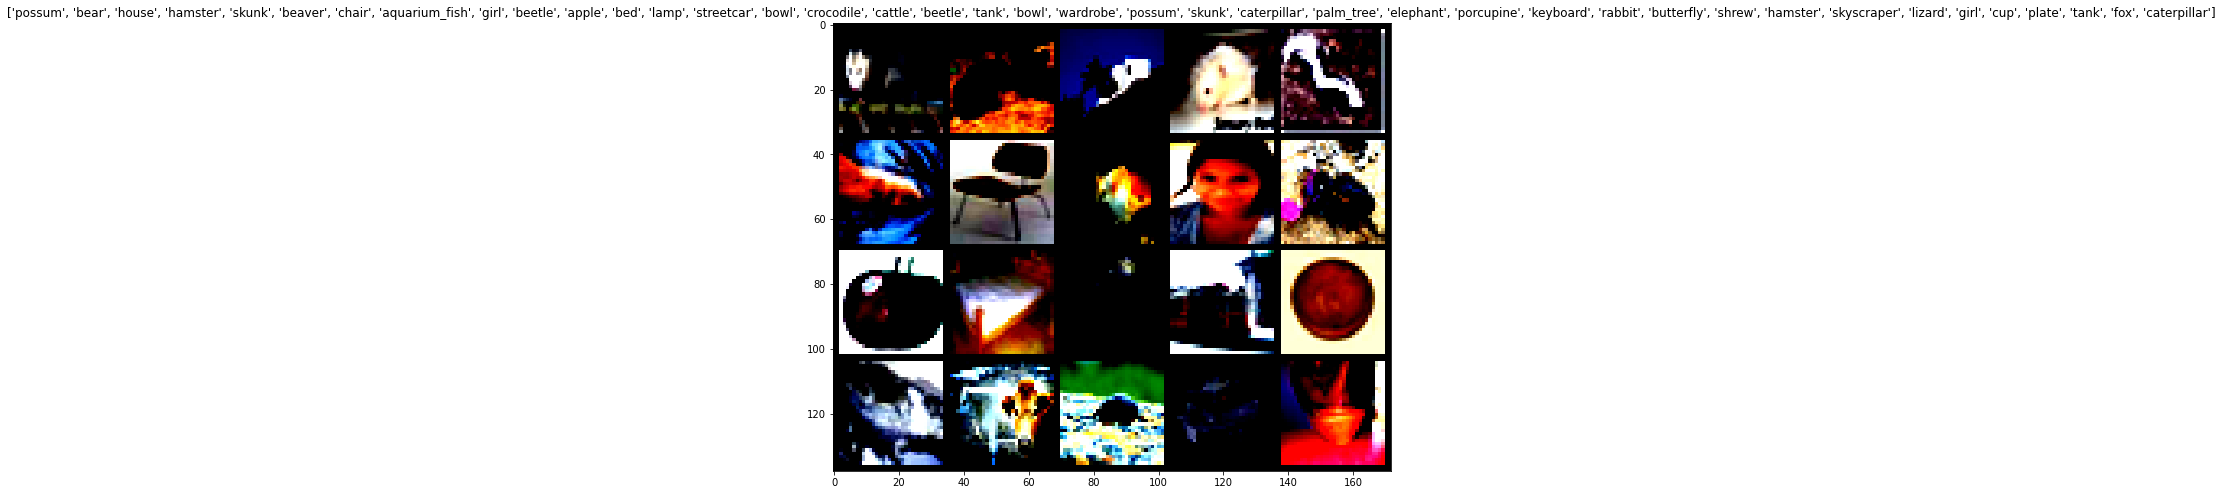

In [ ]:
batch = get_batch(dl_train)
plot_data(batch,classes)

### O Modelo Proposto por Nós

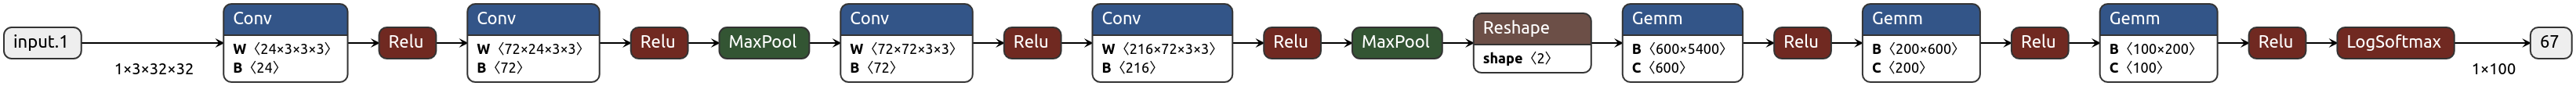

In [ ]:
class CNN100(nn.Module):
  def __init__(self):
    super(CNN100,self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 3)
    self.conv1_bn = nn.BatchNorm2d(24)
    self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 72, kernel_size = 3)
    self.conv2_bn = nn.BatchNorm2d(72)
    self.conv3 = nn.Conv2d(in_channels = 72, out_channels = 72, kernel_size = 3)
    self.conv3_bn = nn.BatchNorm2d(72)
    self.conv4 = nn.Conv2d(in_channels = 72, out_channels = 216, kernel_size = 3)
    self.conv4_bn = nn.BatchNorm2d(216)
    self.pool = nn.MaxPool2d(kernel_size = 2)
    self.dropout = nn.Dropout(p = 0.2)
    self.fc1 = nn.Linear(216*5*5, 600)
    self.fc1_bn = nn.BatchNorm1d(600)
    self.fc2 = nn.Linear(600,200)
    self.fc2_bn = nn.BatchNorm1d(200)
    self.fc3 = nn.Linear(200,100)
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.conv1_bn(x))
    x = self.conv2(x)
    x = F.relu(self.conv2_bn(x))
    x = self.pool(x)

    x = self.conv3(x)
    x = F.relu(self.conv3_bn(x))
    x = self.conv4(x)
    x = F.relu(self.conv4_bn(x))
    x = self.pool(x)

    x = x.view(-1,216*5*5)
   
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc1_bn(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    #x = self.fc2_bn(x)
    
    x = F.relu(self.fc3(x))
    return F.log_softmax(x,dim=1)

In [ ]:
model = CNN100()
model = model.to(get_device())

### Treino

In [ ]:
fit(model,dl_train,num_epochs = 40,steps = 500)

Epoch:  [1/10]: Loss : 0.7548979697227478 Step: 500
Epoch:  [1/10]: Loss : 0.7750200830698013 Step: 1000
Epoch:  [2/10]: Loss : 0.7345870802402497 Step: 500
Epoch:  [2/10]: Loss : 0.7543703808188439 Step: 1000
Epoch:  [3/10]: Loss : 0.6950781853199005 Step: 500
Epoch:  [3/10]: Loss : 0.7332234438657761 Step: 1000
Epoch:  [4/10]: Loss : 0.6689571630954743 Step: 500
Epoch:  [4/10]: Loss : 0.6998268552422523 Step: 1000
Epoch:  [5/10]: Loss : 0.6374185275137424 Step: 500
Epoch:  [5/10]: Loss : 0.6778699829280377 Step: 1000
Epoch:  [6/10]: Loss : 0.622942391872406 Step: 500
Epoch:  [6/10]: Loss : 0.6323981530666352 Step: 1000
Epoch:  [7/10]: Loss : 0.5793165971934795 Step: 500
Epoch:  [7/10]: Loss : 0.6212818048894405 Step: 1000
Epoch:  [8/10]: Loss : 0.5681754693686962 Step: 500
Epoch:  [8/10]: Loss : 0.5876806413829326 Step: 1000
Epoch:  [9/10]: Loss : 0.5392996631264687 Step: 500
Epoch:  [9/10]: Loss : 0.5787914078831673 Step: 1000
Epoch:  [10/10]: Loss : 0.52507360881567 Step: 500
Epoch

### Salvando o Modelo

In [ ]:
torch.save(model,'CNN100.pkl')
model = torch.load('CNN100.pkl')
export_to_onnx(model)

### Test

In [ ]:
test(model,dl_test) #with a little more epochs, we could have more accuracy

Accuracy =  5723 / 10000 57.230000000000004 %


### Métricas de Desempenho

In [ ]:
y_pred = predict(model,ds_test)
y_test = [label for image,label in ds_test]

In [ ]:
print(classification_report(y_test,y_pred,target_names = classes))

               precision    recall  f1-score   support

        apple       0.69      0.86      0.77       100
aquarium_fish       0.82      0.69      0.75       100
         baby       0.43      0.41      0.42       100
         bear       0.27      0.37      0.31       100
       beaver       0.33      0.51      0.40       100
          bed       0.64      0.47      0.54       100
          bee       0.66      0.57      0.61       100
       beetle       0.50      0.71      0.59       100
      bicycle       0.71      0.71      0.71       100
       bottle       0.63      0.74      0.68       100
         bowl       0.51      0.34      0.41       100
          boy       0.32      0.38      0.35       100
       bridge       0.61      0.62      0.62       100
          bus       0.63      0.49      0.55       100
    butterfly       0.61      0.45      0.52       100
        camel       0.41      0.61      0.49       100
          can       0.60      0.54      0.57       100
       ca

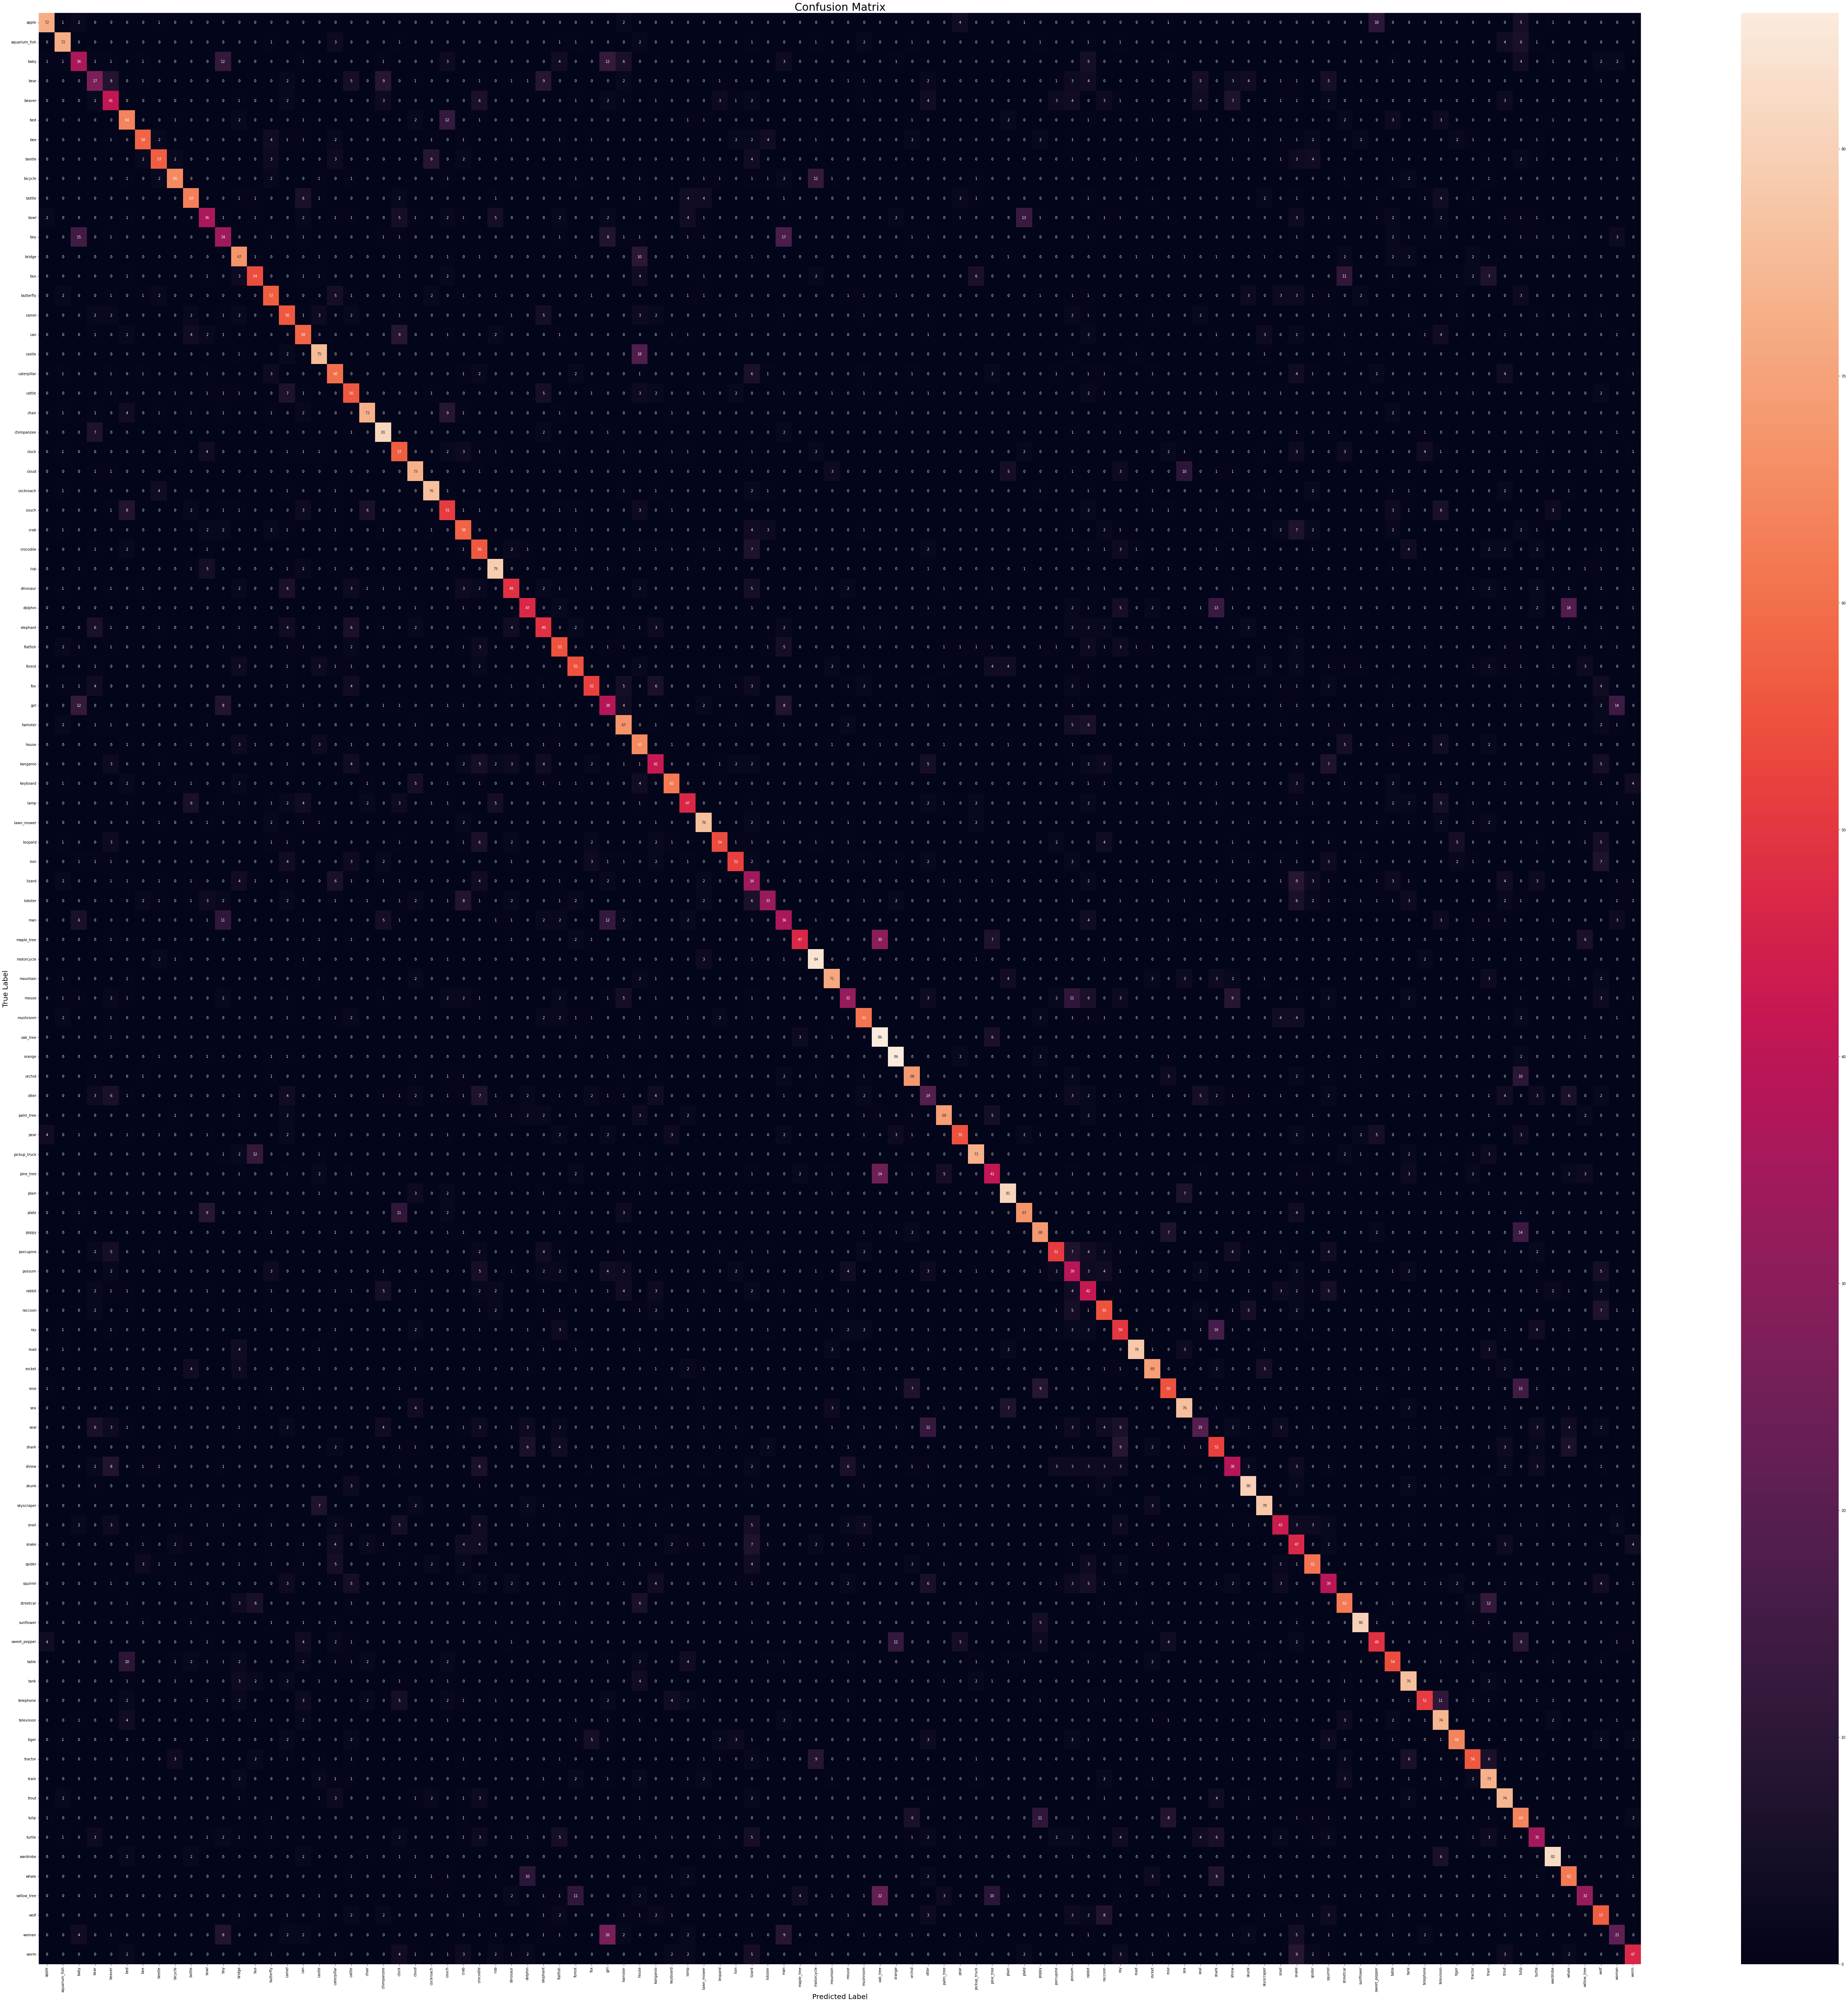

In [ ]:
plot_confusion_matrix(y_test,y_pred,classes,figsize = (100,100))